# Movie Recommendation System (Content-based system)

### Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import difflib
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 

### Importing datsets & Data Preprocessing

In [2]:
def load_and_preprocess_data():
    try:
        # Load data
        movies = pd.read_csv("movies.csv")
        ratings = pd.read_csv("ratings.csv")

        # Pivot ratings to create user-movie matrix
        final_dataset = ratings.pivot_table(index='movieId', columns='userId', values='rating')
        final_dataset.fillna(0, inplace=True)

        # Filter out movies and users with low vote counts
        no_movies_voted = ratings.groupby('userId')['rating'].count()
        final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 50].index]
        final_dataset = final_dataset.reset_index()

        return movies, ratings, final_dataset

    except FileNotFoundError:
        print("Error: movies.csv or ratings.csv not found. Please ensure files are in the correct directory.")
        return None, None, None

### Function to get recommended movies

In [3]:
def create_recommendation_model(final_dataset):
    csr_data = csr_matrix(final_dataset.iloc[:, 1:].values)
    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
    knn.fit(csr_data)
    return knn, csr_data

### Training datasets with K-NN & SVM models

In [4]:
def train_models(final_dataset):
    X = final_dataset.iloc[:, 1:].values
    y = np.random.randint(0, 2, size=len(X))  # Simulated binary labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train SVM
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    
    precision_svm = precision_score(y_test, y_pred_svm, zero_division=1)
    recall_svm = recall_score(y_test, y_pred_svm, zero_division=1)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    
    print("SVM model -: ")
    print(f"Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}, Accuracy_score : {accuracy_svm:.4f}")
    print("\n")
    
    # Train KNN
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    
    precision_knn = precision_score(y_test, y_pred_knn, zero_division=1)
    recall_knn = recall_score(y_test, y_pred_knn, zero_division=1)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    
    print("K-NN model -:")
    print(f"Precision: {precision_knn:.4f}, Recall: {recall_knn:.4f}, Accuracy_score : {accuracy_knn:.4f}")
    print("\n")
    
    return svm_model, knn_model

### Visualisations of the result 

In [5]:
def visualize_model_performance(y_test, y_pred_svm, y_pred_knn):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    cm_svm = confusion_matrix(y_test, y_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title("SVM Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    
    cm_knn = confusion_matrix(y_test, y_pred_knn)
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title("KNN Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    
    precision_svm = precision_score(y_test, y_pred_svm, zero_division=1)
    recall_svm = recall_score(y_test, y_pred_svm, zero_division=1)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    
    precision_knn = precision_score(y_test, y_pred_knn, zero_division=1)
    recall_knn = recall_score(y_test, y_pred_knn, zero_division=1)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    
    metrics_df = pd.DataFrame({
        "Model": ["SVM", "KNN"],
        "Precision": [precision_svm, precision_knn],
        "Recall": [recall_svm, recall_knn],
        "Accuracy": [accuracy_svm, accuracy_knn]
    })
    metrics_df.set_index("Model", inplace=True)
    metrics_df.plot(kind='bar', ax=axes[2], colormap='viridis', alpha=0.75)
    axes[2].set_title("Model Performance Comparison")
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel("Score")
    
    plt.tight_layout()
    plt.show()

def visualise(final_dataset):
    X = final_dataset.iloc[:, 1:].values
    y = np.random.randint(0, 2, size=len(X))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    svm_model = SVC()
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    
    visualize_model_performance(y_test, y_pred_svm, y_pred_knn)
    
    return svm_model, knn_model

### Getting movie recommendation on the input movie

In [6]:
def get_movie_recommendation(movie_name, movies, final_dataset, knn, csr_data, n_movies_to_recommend=10):
    list_of_all_titles = movies['title'].tolist()
    closest_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1)
    
    if not closest_match:
        print("No matching movie found. Please check your input.")
        return None
    
    selected_movie = closest_match[0]
    movie_idx = movies[movies['title'] == selected_movie]['movieId'].values[0]
    
    if movie_idx not in final_dataset['movieId'].values:
        print("Movie not found in dataset for recommendations.")
        return None
    
    movie_matrix_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
    distances, indices = knn.kneighbors(csr_data[movie_matrix_idx], n_neighbors=n_movies_to_recommend+1)    
    rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), 
                                key=lambda x: x[1])[:0:-1]
    
    recommend_frame = []
    similarities = []
    
    for val in rec_movie_indices:
        rec_movie_id = final_dataset.iloc[val[0]]['movieId']
        idx = movies[movies['movieId'] == rec_movie_id].index[0]
        similarities.append(val[1])
        recommend_frame.append({'Title': movies.iloc[idx]['title'], 'Distance': val[1]})
    
    df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend+1))
    
    try:
        res = statistics.variance(similarities)
        print(f"Variance of recommendation similarities: {res:.4f}")
    except statistics.StatisticsError:
        print("Not enough data to calculate variance.")
    
    return df

SVM model -: 
Precision: 0.4786, Recall: 0.5716, Accuracy_score : 0.4828


K-NN model -:
Precision: 0.4970, Recall: 0.5204, Accuracy_score : 0.5049




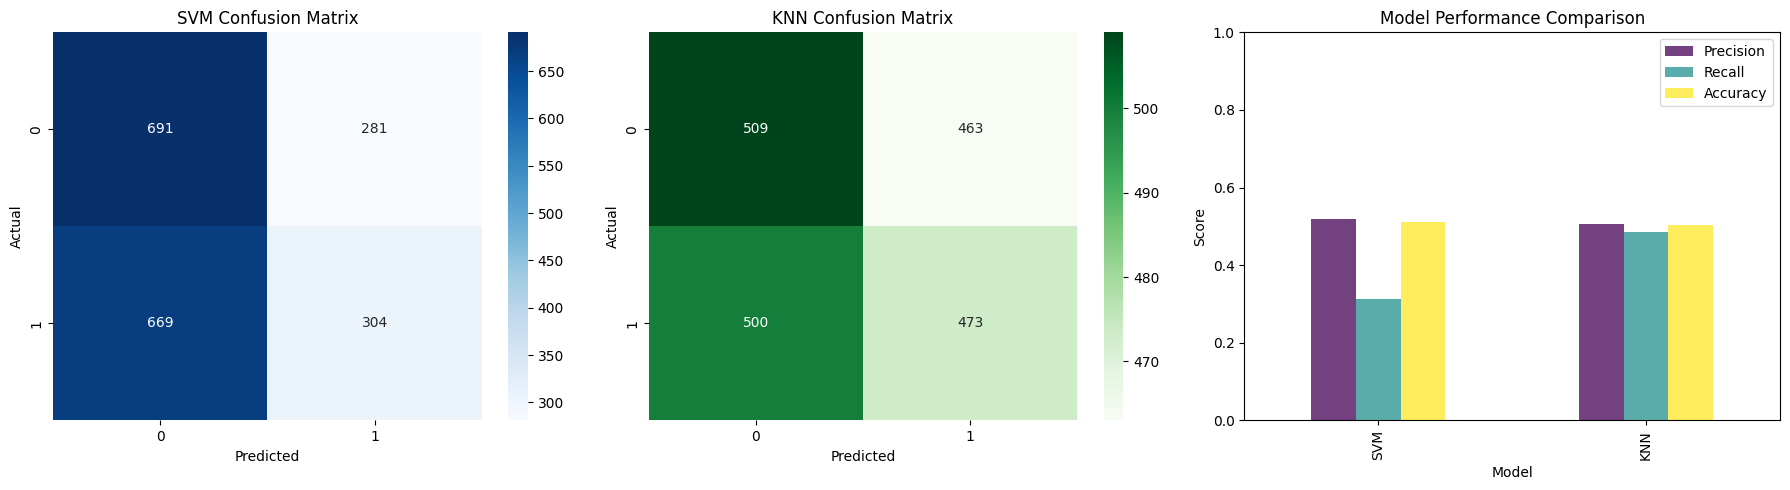

Variance of recommendation similarities: 0.0016

Recommended Movies:
                      Title  Distance
1         Zombieland (2009)  0.398180
2          Inception (2010)  0.393521
3        I Am Legend (2007)  0.389856
4      Hangover, The (2009)  0.364190
5   Dark Knight, The (2008)  0.358937
6      Kung Fu Panda (2008)  0.358604
7           Iron Man (2008)  0.310893
8         District 9 (2009)  0.309947
9             WALL·E (2008)  0.306969
10                Up (2009)  0.289607


No matching movie found. Please check your input.


Variance of recommendation similarities: 0.0016

Recommended Movies:
                      Title  Distance
1         Zombieland (2009)  0.398180
2          Inception (2010)  0.393521
3        I Am Legend (2007)  0.389856
4      Hangover, The (2009)  0.364190
5   Dark Knight, The (2008)  0.358937
6      Kung Fu Panda (2008)  0.358604
7           Iron Man (2008)  0.310893
8         District 9 (2009)  0.309947
9             WALL·E (2008)  0.306969
10        

In [7]:
def main():
    movies, ratings, final_dataset = load_and_preprocess_data()
    
    if movies is None or ratings is None or final_dataset is None:
        return
    
    knn, csr_data = create_recommendation_model(final_dataset)
    
    train_models(final_dataset)
    visualise(final_dataset)
    
    while True:
        movie_name = input('Enter your favorite movie name (or "quit" to exit): ')
        
        if movie_name.lower() == 'quit':
            break
        
        recommendations = get_movie_recommendation(movie_name, movies, final_dataset, knn, csr_data)
        
        if recommendations is not None:
            print("\nRecommended Movies:")
            print(recommendations)
        
        print("\n")

if __name__ == "__main__":
    main()